# Ultimate Take Home Challenge

## Part 1 - EDA

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [620]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.cluster import KMeans

In [391]:
with open('logins.json') as file:
  data = json.load(file)

In [392]:
df = pd.DataFrame(data)

In [393]:
df['count'] = 1

In [394]:
df.set_index(pd.to_datetime(df.login_time), inplace=True)

In [395]:
df.drop('login_time', inplace=True, axis=1)

In [396]:
resample_15m = df.resample('15Min').count()

In [397]:
resample_15m.describe()

,count
count,9788.000000
mean,9.515938
std,8.328818
min,0.000000
25%,3.000000
50%,7.000000
75%,13.000000
max,73.000000


Text(0.5, 1.0, 'Number of logins per 15 minute intervals')

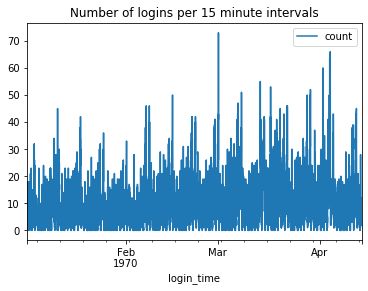

In [398]:
resample_15m.plot()
plt.title('Number of logins per 15 minute intervals')

In [399]:
resample_d = df.resample('D').count()

Text(0.5, 1.0, 'Number of logins per day')

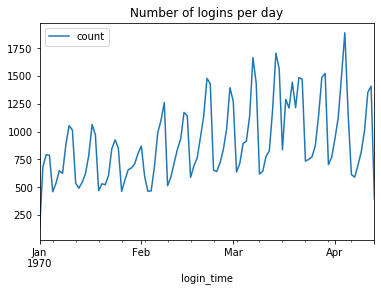

In [400]:
resample_d.plot()
plt.title('Number of logins per day')

In [402]:
df['dow'] = df.index.dayofweek
resample_w = df.resample('W').count()
num_weeks = len(resample_w)

Text(0.5, 1.0, 'Weekly login trend')

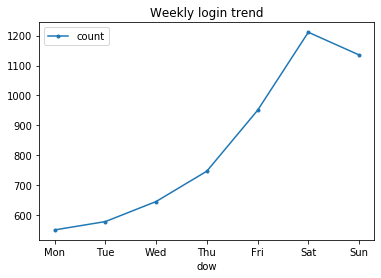

In [404]:
(df.groupby('dow').count()/num_weeks).plot(marker='.')
plt.xticks(np.arange(0,7),['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.title('Weekly login trend')

In [ ]:
#increasing activity throughout the week
#more activity during the weekend

In [405]:
decomposition = seasonal_decompose(resample_15m, model='additive', period=4*24*7)

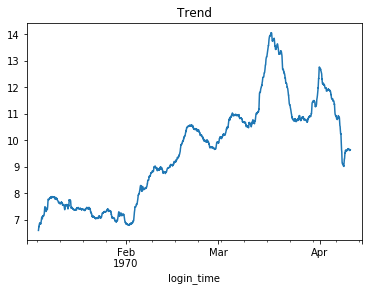

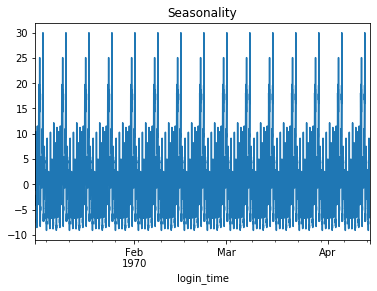

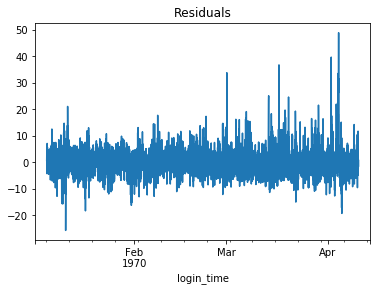

In [406]:
decomposition.trend.plot()
plt.title('Trend')
plt.show()
decomposition.seasonal.plot()
plt.title('Seasonality')
plt.show()
decomposition.resid.plot()
plt.title('Residuals')
plt.show()

In [409]:
df['hour']= df.index.hour

Text(0.5, 1.0, 'Average number of logins per hour')

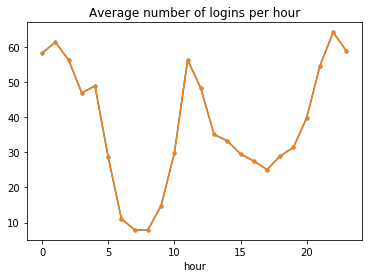

In [413]:
(df.groupby('hour').count()/len(resample_d)).plot(marker='.', legend=False)
plt.title('Average number of logins per hour')

In [ ]:
#peaks during lunch time and after work (11-12pm, 9pm-4am)
#troughs during commute times (6am - 9am, 3pm-7pm)

In [317]:
weekend = df[(df.dow ==5) | (df.dow==6)]

In [318]:
weekday = df[~((df.dow ==5) | (df.dow==6))]

In [363]:
weekend_resampled = weekend.resample('D').count()
weekend_resampled = weekend_resampled.replace(0, np.nan)
num_weekend_days = weekend_resampled['count'].count()

Text(0.5, 1.0, 'Average number of logins per hour on weekends')

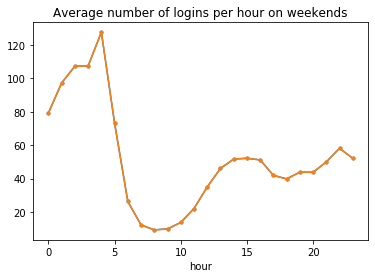

In [410]:
(weekend.groupby('hour').count()/num_weekend_days).plot(marker='.', legend=False)
plt.title('Average number of logins per hour on weekends')

In [411]:
weekday_resampled = weekday.resample('D').count()
weekday_resampled = weekday_resampled.replace(0, np.nan)
num_weekday_days = weekday_resampled['count'].count()

Text(0.5, 1.0, 'Average number of logins per hour on weekdays')

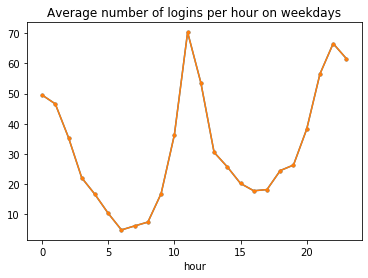

In [412]:
(weekday.groupby('hour').count()/num_weekday_days).plot(marker='.', legend=False)
plt.title('Average number of logins per hour on weekdays')

# Part 2 - Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

#### Answers:
1. I would define the key measure of success as seeing a significant increase in the number of times driver partners cross the bridge after the intervention. I would choose this metric because it directly measures the effectiveness of the intervention
2. I would randomly assign partner drivers to a control group and an experimental group. For the control group, nothing would change. For the experimental group, I would offer to reimburse toll costs. Then I would measure the number of times drivers used the bridge for a certain amount of time (e.g. one month). After all the data is collected, I would carry out a normal test to see if the samples are normally distributed. If they are, I would carry out an independent samples t-test. If they are not normally distributed, I would carry out a Mann Whiteny test, which is a non-parametric version of the independent samples t test. If the p value of either test is less than .05, this would indicate that the samples are significantly different from each other, meaning that the intervention is effective and should be implemented. 

## Part 3 - Predicitve Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

### Data description

* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYY MM DD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

In [417]:
with open('ultimate_data_challenge.json') as file:
    data = json.load(file)

In [471]:
df = pd.DataFrame(data)

In [472]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [473]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [474]:
#change date columns to datetime objects
df['signup_date'] = pd.to_datetime(df.signup_date)
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)

In [492]:
#fill in null values 
df.avg_rating_of_driver.fillna(round(df.avg_rating_of_driver.mean(), 1), inplace=True)
df.avg_rating_by_driver.fillna(round(df.avg_rating_by_driver.mean(), 1), inplace=True)
df.phone.fillna(df.phone.value_counts().idxmax(), inplace=True)

In [493]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [494]:
#create label column
df['active'] = df.last_trip_date >= '2014-06-01'

Text(0.5, 1, 'correlation heatmap of numeric features')

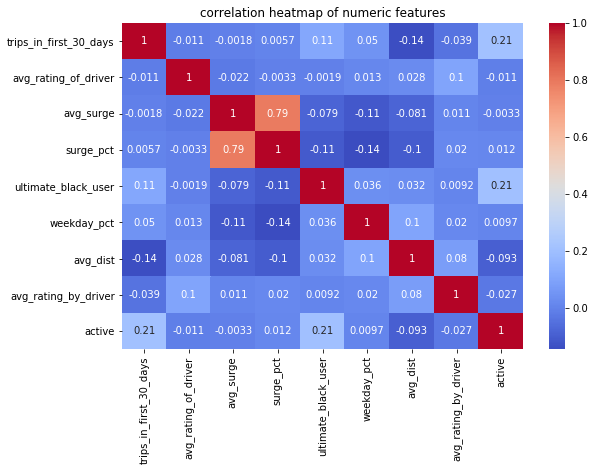

In [518]:
#heatmap
plt.figure(figsize=(9,6))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.title('correlation heatmap of numeric features')

trips_in_first_30_days and ultimate_black_user are most correlated with retention

In [ ]:
#categorical EDA

Text(0.5, 1.0, 'Retention counts 6 months after signup')

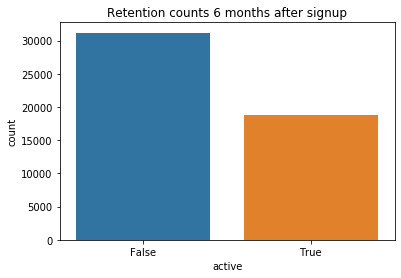

In [526]:
sns.countplot(df.active)
plt.title('Retention counts 6 months after signup')

In [517]:
print("Overall likelihood of retention 6 months after sign up:")
df.active.value_counts()/ len(df) * 100

Overall likelihood of retention 6 months after sign up:


False    62.392
True     37.608
Name: active, dtype: float64

Text(0.5, 1.0, 'Retention counts per city')

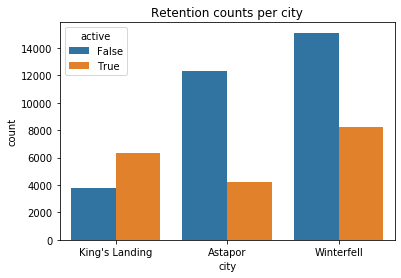

In [523]:
sns.countplot(df.city, hue=df.active)
plt.title('Retention counts per city')

more likely to be active in King's Landing

Text(0.5, 1.0, 'Retention counts per phone type')

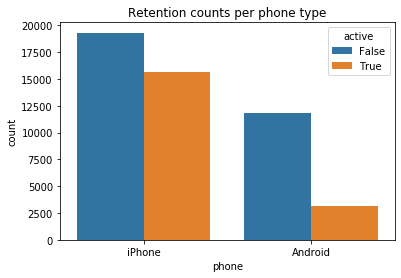

In [524]:
sns.countplot(df.phone, hue=df.active)
plt.title('Retention counts per phone type')

more likely to be active if iphone user

In [ ]:
#preprocessing

In [555]:
model_df = df.copy()

In [556]:
#one hot encoding
model_df['is_iphone'] = model_df.phone.apply(lambda x: 1 if x== 'iPhone' else 0)
model_df['ultimate_black_user'] = model_df.ultimate_black_user * 1
model_df['active'] = model_df.active * 1

In [557]:
dummies = pd.get_dummies(model_df.city, drop_first=True)
model_df = pd.concat([model_df.drop(['signup_date', 'last_trip_date', 'phone', 'city'], axis=1), dummies], axis=1)

In [567]:
#split features and label
X = model_df.drop('active', axis=1)
y = model_df.active

In [572]:
#scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [573]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=.2, random_state =123)

In [583]:
#logistic Regression model
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print(classification_report(y_test, lr_preds))
print(confusion_matrix(y_test, lr_preds))
print(roc_auc_score(y_test, lr_preds))

              precision    recall  f1-score   support

           0       0.73      0.85      0.79      6218
           1       0.67      0.49      0.56      3782

    accuracy                           0.72     10000
   macro avg       0.70      0.67      0.68     10000
weighted avg       0.71      0.72      0.70     10000

[[5308  910]
 [1937 1845]]
0.6707439073779592


In [584]:
#random forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
print(classification_report(y_test, rf_preds))
print(confusion_matrix(y_test, rf_preds))
print(roc_auc_score(y_test, rf_preds))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      6218
           1       0.68      0.65      0.67      3782

    accuracy                           0.76     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.75      0.76      0.75     10000

[[5078 1140]
 [1309 2473]]
0.7352740691249828


In [616]:
#improve performance by clustering samples into 2 groups
km = KMeans(n_clusters=2)
km.fit(X)
preds = km.predict(X)
cluster_model = model_df.copy()
cluster_model['cluster'] = preds
X = cluster_model.drop('active', axis=1)
y = cluster_model.active

In [617]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state =123)

In [618]:
#retrain rf with clusters as features
rf2 = RandomForestClassifier()
rf2.fit(X_train, y_train)
rf2_preds = rf2.predict(X_test)
print(classification_report(y_test, rf2_preds))
print(confusion_matrix(y_test, rf2_preds))
print(roc_auc_score(y_test, rf2_preds))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      6218
           1       0.69      0.66      0.67      3782

    accuracy                           0.76     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.76      0.76      0.76     10000

[[5080 1138]
 [1277 2505]]
0.7396654583790532


In [621]:
#grid search to tune parameters
params = {'n_estimators':[10,50,100,150,200], 'criterion': ['gini', 'entropy'], 'max_depth':[10, 50, 100, None]}
rf_cv = RandomizedSearchCV(RandomForestClassifier(), params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.9min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [622]:
#retrain random forest model with best parameters
rf3 = RandomForestClassifier(**rf_cv.best_params_, random_state = 42)
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}
0.8508436559801338


In [623]:
rf3.fit(X_train, y_train)
rf3_preds = rf3.predict(X_test)
print(classification_report(y_test, rf3_preds))
print(confusion_matrix(y_test, rf3_preds))
print(roc_auc_score(y_test, rf3_preds))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      6218
           1       0.75      0.65      0.69      3782

    accuracy                           0.78     10000
   macro avg       0.78      0.76      0.76     10000
weighted avg       0.78      0.78      0.78     10000

[[5395  823]
 [1331 2451]]
0.7578560665296961


In [642]:
pd.Series(rf3.feature_importances_, index=X.columns).sort_values(ascending=False)

avg_rating_by_driver      0.181156
King's Landing            0.141048
surge_pct                 0.130823
weekday_pct               0.119283
avg_surge                 0.102554
is_iphone                 0.074768
trips_in_first_30_days    0.067749
ultimate_black_user       0.062627
avg_dist                  0.059114
avg_rating_of_driver      0.031083
cluster                   0.016505
Winterfell                0.013291
dtype: float64

The top 3 most important features considered by the model were the average rating by the driver, whether or not the rider lives in King's Landing, and the percent of rides that were surge pricing